<a href="https://colab.research.google.com/github/saidKhatir/LaDech35/blob/main/Copie_de_OsmVsBDTopo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⏮ Chargement des couches

## Chargement des bibliothèques python

In [ ]:
!pip install geojson
!pip install overpass
!pip install contextily


import re
import requests
import geopandas as gpd
import pandas as pd
import geojson
import overpass
from overpass.errors import UnknownOverpassError
from shapely.geometry import Polygon, MultiPoint
import matplotlib.pyplot as plt
import geopandas as gdf
import contextily as ctx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 55.2 MB/s eta 0:00:00


## Appel vers les API et flux WFS pour récupérer les points de vues

In [ ]:
# Available themes
THEMES = [
    "view_point",
    "parkings",
]
# API endpoints
URL_OWS = "https://data.geopf.fr/wfs/ows?"
API_CARTO_CADASTRE = f"https://apicarto.ign.fr/api/cadastre"
# WFS basic parameters for IGN
WFS_PARAMS = dict(
    SERVICE="WFS",
    VERSION="2.0.0",
    REQUEST="GetFeature",
    OUTPUTFORMAT="json",
)
# IGN names of layers
IGN_NAMES = dict(
    view_point="BDTOPO_V3:zone_d_activite_ou_d_interet",
    parkings="BDTOPO_V3:equipement_de_transport",
)
# Dict of Queries
OSM_QUERIES = dict(
    view_point='(area["ref:INSEE"="{}"];)->.com;node["tourism"="viewpoint"](area.com);',
    parkings='(area["ref:INSEE"="{}"];)->.com;way["amenity"="parking"](area.com);',
)
IGN_QUERIES = dict(
    view_point="nature = 'Point de vue' AND WITHIN(geometrie, {})",
    parkings="nature = 'Parking' AND WITHIN(geometrie, {})",
)


def invert_coords(geom:Polygon) -> Polygon:
    coords = list(geom.exterior.coords)
    coords = [(y,x) for x,y in coords]
    return Polygon(coords)


def get_bbox(data:gpd.GeoDataFrame) -> str:
    bbox = data.envelope[0]
    bbox = str(invert_coords(bbox))
    bbox = bbox.replace("POLYGON ((", "Polygon((")
    return bbox


def line_string_to_pol(
    gjson:geojson.FeatureCollection,
) -> geojson.FeatureCollection:
    converted = gjson
    for f in converted.features:
        if f.geometry.type == "LineString":
            f.geometry.type = "Polygon"
            f.geometry.coordinates = [f.geometry.coordinates]
    return converted


# TODO: check resulst... Crozon is very strange
def get_com(code_insee:int) -> gpd.GeoDataFrame:
    # create url
    url_com = f"{API_CARTO_CADASTRE}/commune?code_insee={code_insee}"
    # Fecth data
    com_r = requests.get(url_com)
    # Transform to gpd.GeoDataFrame
    com = gpd.GeoDataFrame.from_features(
        geojson.loads(com_r.content,),
        crs="EPSG:4326",
    )
    return com


# WARN: les champs de localisation sont vraiment naze... Il faut donc passer par
# une requête spatiale et ce n'est vraiment pas performant
# WARN: l'IGN s'est dit que c'était une bonne idée de mettre les points de vue
# polygon... Donc on les converti en poit en calculant le centroid.
# TODO: handle len(r) == 0
# TODO: handle warning when intersected.centroid
def get_bdtopo(
    name:str,
    code_insee:int,
) -> (gpd.GeoDataFrame | pd.DataFrame | pd.Series):
    if name not in THEMES:
        raise ValueError("The provided name is not available")

    # Compute bbox
    com = get_com(code_insee)
    bbox = get_bbox(com)

    # get parameters
    params = WFS_PARAMS
    params["TYPENAME"] = IGN_NAMES[name]
    params["cql_filter"] = IGN_QUERIES[name]

    # Set bbox in query
    params["cql_filter"] = re.sub("{}", bbox, params["cql_filter"])

    # Fetch data
    r = requests.get(URL_OWS, params=params)

    raw = gpd.GeoDataFrame.from_features(
        geojson.loads(r.content),
        crs="EPSG:4326",
    )

    # Get data that are in the com
    intersected = raw.overlay(com, how="intersection")

    # If viewpoint == viewpoint, compute centroid (because data are point of
    # view)
    if name == "view_point":
        intersected.geometry = intersected.centroid

    return intersected


def get_osm(name:str, code_insee:int) -> gpd.GeoDataFrame:
    if name not in THEMES:
        raise ValueError("The provided name is not available")

    # instatiate class with timeout to 60s
    api = overpass.API(timeout=60)

    # retrieve query
    query = OSM_QUERIES[name]
    # Set code_insee
    query = re.sub("{}", str(code_insee), query)

    # Fetch data (returns geojson)
    try:
        if name == "parkings":
            r = api.get(query, verbosity="geom")
        else:
            r = api.get(query)
    except UnknownOverpassError as e:
        raise Exception(f"Overpass error : {e}")

    if len(r.features[0].geometry.coordinates) == 0:
        raise Exception("No entity was found")

    # If ways, convert LineString to Polygon
    if name == "parkings":
        r = line_string_to_pol(r)

    # Convert to GeoDataFrame
    data = gpd.GeoDataFrame.from_features(r, crs="EPSG:4326",)

    return data


## Choisir la commune d'étude

In [ ]:

code_insee = 29019
name = "view_point"

# Get bdtop data
print("Fetching IGN data...")
data_bdtopo = get_bdtopo(name=name, code_insee=code_insee)
print("Fetching OSM data...")
data_osm = get_osm(name=name, code_insee=code_insee)
data_osm.plot

Fetching IGN data...


<ipython-input-3-ed3e6ae020d1>:109: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersected.geometry = intersected.centroid


Fetching OSM data...


## Afficher la localisation des points de vues entre les deux bases

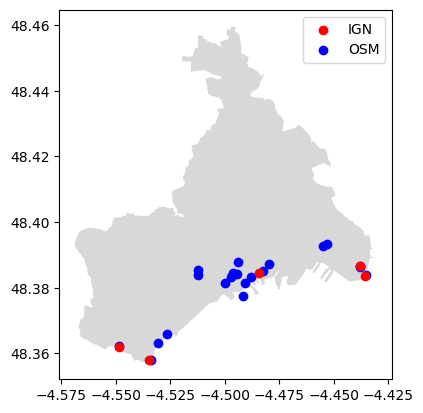

In [ ]:
# Afficher la localisation des points de vues entre les deux bases

com = get_com(code_insee)

_, ax = plt.subplots(nrows=1, ncols=1)
com.plot(ax=ax, color="Grey", alpha=0.3, zorder = 1)
data_bdtopo.plot(ax=ax, color="Red", label="IGN", zorder = 3)
data_osm.plot(ax=ax, color="Blue", label="OSM", zorder = 2)
plt.legend()
plt.show()


data_osm.to_file("PV_osm", layer='data_osm', driver="GPKG")
data_bdtopo.to_file("PV_bdtopo", layer='data_bdtopo', driver='GPKG')

PV_osm = data_osm
PV_bdtopo = data_bdtopo

# 🔎 Analyses des résultats

### 🔀 Analyse attributaire

In [ ]:
#Checker les types des champs de la couche point de vue de la BDTOPO
PV_bdtopo.dtypes

cleabs                                   object
categorie                                object
nature                                   object
nature_detaillee                         object
toponyme                                 object
statut_du_toponyme                       object
importance                               object
fictif                                     bool
etat_de_l_objet                          object
date_creation                            object
date_modification                        object
date_d_apparition                        object
date_de_confirmation                     object
sources                                  object
identifiants_sources                     object
methode_d_acquisition_planimetrique      object
precision_planimetrique                   int64
identifiant_voie_ban                     object
nom_commercial                           object
nom_com                                  object
code_dep                                

In [ ]:
#Checker les types des champs de la couche point de vue de la base OSM
PV_osm.dtypes

geometry          geometry
tourism             object
name                object
wheelchair          object
name:br             object
source:name:br      object
ele                 object
man_made            object
tower:type          object
ID                   int64
dtype: object

In [ ]:
# Ajouter un nouveau champ ID
PV_bdtopo['ID'] = PV_bdtopo.index
PV_osm['ID'] = PV_osm.index

# Calculer le nombre de points de vue dans la commune dans la base OSM
total_rows_bdtopo = PV_bdtopo["ID"].size

# Afficher le résultat
print("Le nombre de points de vue dans la commune dans la BDTOPO est de :", total_rows_bdtopo)

# Calculer le nombre de points de vue dans la commune dans la base OSM
total_rows_osm = PV_osm["ID"].size

# Afficher le résultat
print("Le nombre de points de vue dans la commune dans la base OSM est de :", total_rows_osm)

Le nombre de points de vue dans la commune dans la BDTOPO est de : 5
Le nombre de points de vue dans la commune dans la base OSM est de : 22


In [ ]:
# Calculer le taux de remplissage des attributs pour chaque colonne
fill_rates = {column: (PV_osm[column].notna().sum() / total_rows_osm) * 100 for column in PV_osm.columns}

# Trier les taux de remplissage par ordre croissant
sorted_fill_rates = sorted(fill_rates.items(), key=lambda x: x[1], reverse=True)

# Calculer le taux de remplissage total
total_non_null = sum(PV_osm[column].notna().sum() for column in PV_osm.columns)
total_fill_rate = (total_non_null / (total_rows_osm * len(fill_rates))) * 100

# Afficher le taux de remplissage total en première ligne en gras
print(f"\033[1mLe taux de remplissage total est des attributs est de {total_fill_rate:.2f}%\033[0m")

# Afficher les taux de remplissage pour chaque colonne par ordre croissant
for column, fill_rate in sorted_fill_rates:
    print(f"'{column}' est de {fill_rate:.2f}%")


Le taux de remplissage total est des attributs est de 36.36%
'geometry' est de 100.00%
'tourism' est de 100.00%
'ID' est de 100.00%
'name' est de 27.27%
'wheelchair' est de 13.64%
'name:br' est de 4.55%
'source:name:br' est de 4.55%
'ele' est de 4.55%
'man_made' est de 4.55%
'tower:type' est de 4.55%


In [ ]:
# Calculer le taux de remplissage des attributs pour chaque colonne
fill_rates = {column: (PV_bdtopo[column].notna().sum() / total_rows_bdtopo) * 100 for column in PV_bdtopo.columns}

# Trier les taux de remplissage par ordre croissant
sorted_fill_rates = sorted(fill_rates.items(), key=lambda x: x[1], reverse = True)

# Calculer le taux de remplissage total
total_non_null = sum(PV_bdtopo[column].notna().sum() for column in PV_bdtopo.columns)
total_fill_rate = (total_non_null / (total_rows_bdtopo * len(fill_rates))) * 100

# Afficher le taux de remplissage total en première ligne en gras
print(f"\033[1mLe taux de remplissage total des attributs est de {total_fill_rate:.2f}%\033[0m")

# Afficher les taux de remplissage pour chaque colonne par ordre croissant
for column, fill_rate in sorted_fill_rates:
    print(f"'{column}' est de {fill_rate:.2f}%")

Le taux de remplissage total des attributs est de 69.17%
'cleabs' est de 100.00%
'categorie' est de 100.00%
'nature' est de 100.00%
'importance' est de 100.00%
'fictif' est de 100.00%
'etat_de_l_objet' est de 100.00%
'date_creation' est de 100.00%
'date_modification' est de 100.00%
'methode_d_acquisition_planimetrique' est de 100.00%
'precision_planimetrique' est de 100.00%
'nom_com' est de 100.00%
'code_dep' est de 100.00%
'code_insee' est de 100.00%
'geometry' est de 100.00%
'ID' est de 100.00%
'date_de_confirmation' est de 80.00%
'nature_detaillee' est de 20.00%
'toponyme' est de 20.00%
'statut_du_toponyme' est de 20.00%
'identifiant_voie_ban' est de 20.00%
'date_d_apparition' est de 0.00%
'sources' est de 0.00%
'identifiants_sources' est de 0.00%
'nom_commercial' est de 0.00%


In [ ]:
# Afficher la différence du nombre d'entités
difference = total_rows_osm - total_rows_bdtopo

print(f"\033[1mLa différence du nombre de points entre OSM et BDTOPO est de {difference} points.\033[0m")


La différence du nombre de points entre OSM et BDTOPO est de 17 points.


## **🌎** Analyse spatiale

### Calculer les emprises spatiales des points de vues entre BDTOPO et OSM

In [ ]:
# Reprojeter la couche en 2154
PV_osm_ok = PV_osm.to_crs(2154)
PV_bdtopo_ok = PV_bdtopo.to_crs(2154)
com_ok = com.to_crs(2154)

In [ ]:
# Créer une géométrie MultiPoint à partir des points
PV_bdtopo_multi = MultiPoint(PV_bdtopo_ok.geometry)

# Calculer l'enveloppe convexe
enveloppe_convexe = PV_bdtopo_multi.convex_hull

# Créer un GeoDataFrame pour l'enveloppe convexe
enveloppe_convexe_bdtopo = gpd.GeoDataFrame(geometry=[enveloppe_convexe])


In [ ]:
# Créer une géométrie MultiPoint à partir des points
PV_osm_multi = MultiPoint(PV_osm_ok.geometry)

# Calculer l'enveloppe convexe
enveloppe_convexe = PV_osm_multi.convex_hull

# Créer un GeoDataFrame pour l'enveloppe convexe
enveloppe_convexe_osm = gpd.GeoDataFrame(geometry=[enveloppe_convexe])


In [ ]:
def calculer_superficie_enveloppe_convexe(enveloppe_convexe, nom_couche):
    # Calculer la superficie de l'enveloppe convexe en km²
    superficie_enveloppe_convexe = round(enveloppe_convexe.area.values[0] / 10**6, 2)

    # Afficher la superficie
    print(f"La superficie de l'enveloppe convexe de {nom_couche} est de : {superficie_enveloppe_convexe} km²")

# Appeler la fonction pour PV_osm
calculer_superficie_enveloppe_convexe(enveloppe_convexe_osm, "OSM")

# Appeler la fonction pour PV_bdtopo
calculer_superficie_enveloppe_convexe(enveloppe_convexe_bdtopo, "BDTOPO")


La superficie de l'enveloppe convexe de OSM est de : 13.82 km²
La superficie de l'enveloppe convexe de BDTOPO est de : 8.55 km²


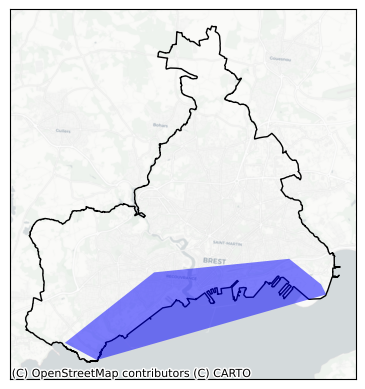

In [ ]:

# Afficher l'emprise de la commune et l'enveloppe convexe sur la même figure
ax = com_ok.plot(edgecolor='black', facecolor='none')
enveloppe_convexe_osm.plot(ax=ax, facecolor='blue', alpha=0.5)
# Ajouter un fond de carte avec contextily en spécifiant le CRS
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:2154')

# Supprimer les graduations sur les axes x et y
ax.set_xticks([])
ax.set_yticks([])

# Afficher la carte
plt.show()

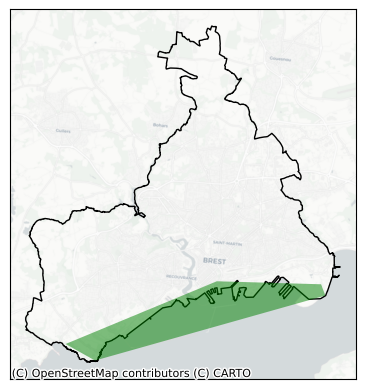

In [ ]:

# Afficher l'emprise de la commune et l'enveloppe convexe sur la même figure
ax = com_ok.plot(edgecolor='black', facecolor='none')
enveloppe_convexe_bdtopo.plot(ax=ax, facecolor='green', alpha=0.5)
# Ajouter un fond de carte avec contextily en spécifiant le CRS
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:2154')

# Supprimer les graduations sur les axes x et y
ax.set_xticks([])
ax.set_yticks([])

# Afficher la carte
plt.show()


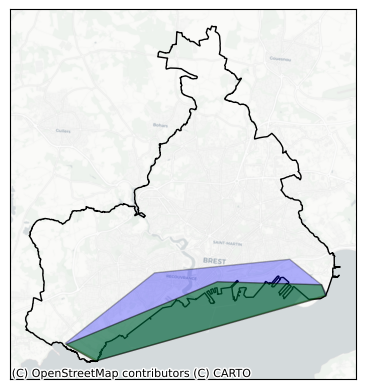

In [ ]:
# Créer une géométrie MultiPoint à partir des points de PV_bdtopo_ok
PV_bdtopo_multi = MultiPoint(PV_bdtopo_ok.geometry)

# Calculer l'enveloppe convexe
enveloppe_convexe_bdtopo = PV_bdtopo_multi.convex_hull

# Créer un GeoDataFrame pour l'enveloppe convexe
enveloppe_convexe_bdtopo = gpd.GeoDataFrame(geometry=[enveloppe_convexe_bdtopo])

# Afficher l'enveloppe convexe sur la même figure que la commune
ax = com_ok.plot(edgecolor='black', facecolor='none', zorder = 2)
enveloppe_convexe_bdtopo.plot(ax=ax, edgecolor='black',facecolor='green', alpha=0.5, zorder = 4)
enveloppe_convexe_osm.plot(ax=ax, edgecolor='black',facecolor='blue', alpha=0.3, zorder = 3)

# Ajouter un fond de carte avec contextily en spécifiant le CRS
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:2154')


# Supprimer les graduations sur les axes x et y
ax.set_xticks([])
ax.set_yticks([])

# Afficher la carte
plt.show()
